<a href="https://colab.research.google.com/github/KhatijaBegum27/AI-ML-Projects/blob/main/GenAILineageTracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# import Libraries
import pandas as pd, numpy as np, networkx as nx, matplotlib.pyplot as plt, gradio as gr
from sklearn.ensemble import IsolationForest
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
# Load Data
transactions = pd.DataFrame({
    "cust_id": [1,2,3,4,5,6],
    "amount": [200,450,13000,500,120,600],
    "age": [25,40,35,60,29,np.nan]
})
customers = pd.DataFrame({
    "cust_id": [1,2,3,4,5],
    "region": ["US","UK","US","IN","CA"]
})

In [29]:
# Build Simple Lineage Graph
def plot_lineage():
    G = nx.DiGraph()
    edges = [("transactions_raw","cleaned_transactions"),
             ("customers_raw","cleaned_customers"),
             ("cleaned_transactions","merged_data"),
             ("cleaned_customers","merged_data"),
             ("merged_data","anomaly_detection")]
    G.add_edges_from(edges)
    nx.draw(G, with_labels=True, node_color="#9dd7f0", node_size=2500, arrows=True)
    plt.title("Data Lineage Graph")
    plt.show()

In [30]:
# Data Quality Check
def dq_report(df, name):
    rep = {
        "stage": name,
        "missing_values": int(df.isna().sum().sum()),
        "duplicates": int(df.duplicated().sum()),
        "outliers": detect_outliers(df)
    }
    return rep

def detect_outliers(df):
    num = df.select_dtypes("number")
    if num.empty: return 0
    model = IsolationForest(contamination=0.15, random_state=42)
    preds = model.fit_predict(num)
    return int((preds == -1).sum())

reports = [dq_report(transactions,"transactions_raw"),
           dq_report(customers,"customers_raw")]


In [36]:
merged = transactions.merge(customers, on="cust_id", how="left")
merged["amount_usd"] = merged["amount"] * np.random.uniform(0.8,1.2,len(merged))
reports = [dq_report(transactions,"transactions_raw"),
           dq_report(customers,"customers_raw"),
           dq_report(merged,"merged_data")]
dq_df = pd.DataFrame(reports)

print("\n Data Quality Report:")
print(dq_df)

print("\n Merged Data Sample:")
print(merged.head())


 Data Quality Report:
              stage  missing_values  duplicates  outliers
0  transactions_raw               1           0         1
1     customers_raw               0           0         1
2       merged_data               2           0         1

 Merged Data Sample:
   cust_id  amount   age region    amount_usd
0        1     200  25.0     US    169.673244
1        2     450  40.0     UK    363.825674
2        3   13000  35.0     US  13888.179285
3        4     500  60.0     IN    524.665631
4        5     120  29.0     CA    139.434590


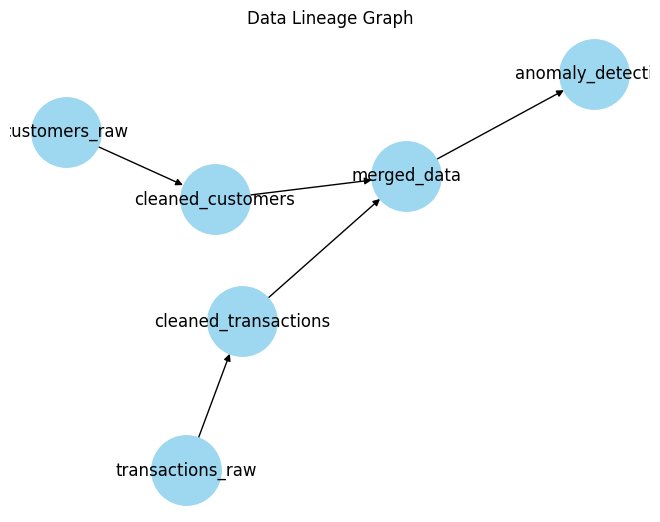

In [37]:
# Plot Lineage Graph
plot_lineage()

In [33]:
# Simple Q&A
docs = [
    "transactions_raw has numeric outliers in amount column",
    "customers_raw has missing join for cust_id 6",
    "merged_data combines customers and transactions with derived column amount_usd"
]

def ask_question(q):
    vect = TfidfVectorizer().fit(docs + [q])
    sim = cosine_similarity(vect.transform([q]), vect.transform(docs))
    return docs[int(sim.argmax())]

In [35]:
print("\n Ask your AI Assistant about the data pipeline! (type 'exit' to quit)\n")
while True:
    q = input("You: ")
    if q.lower() in ["exit", "quit", "q"]:
        print(" Exiting assistant.")
        break
    answer = ask_question(q)
    print("AI Assistant:", answer)


 Ask your AI Assistant about the data pipeline! (type 'exit' to quit)

You: which customer has missing join
AI Assistant: customers_raw has missing join for cust_id 6
You: which stage has missing data
AI Assistant: customers_raw has missing join for cust_id 6
You: what does merged data contain
AI Assistant: transactions_raw has numeric outliers in amount column
You: what does merged_data contain?
AI Assistant: merged_data combines customers and transactions with derived column amount_usd
You: quit
 Exiting assistant.
